Dataset figure

(270, 480, 3)
(540, 960, 3)


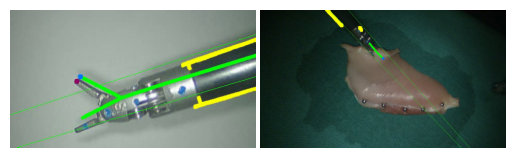

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2

d1 = cv2.imread('jrn_li.png')
#d2 = cv2.imread('dtd_endpi.png')
d2 = cv2.imread('dtd_li.png')

print(d1.shape)
print(d2.shape)

d1_cropped = d1[100:300, 115:400, :]
d2_cropped = d2[0:275, 225:510, :]

fig, ax = plt.subplots(nrows=1, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0].imshow(d1) 
ax[0].axis('off')
ax[1].imshow(d2)
ax[1].axis('off')

plt.subplots_adjust(wspace = 0.02)
plt.savefig('dataset_images.pdf', bbox_inches = 'tight')



Heatmap Figure

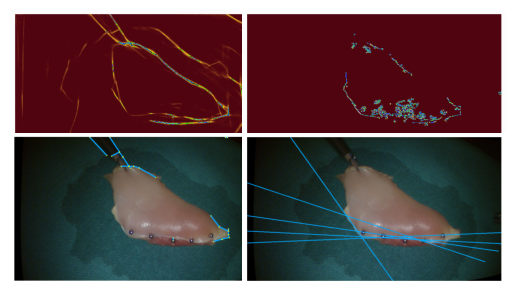

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2

img1 = cv2.imread('dtd_sold2lineheatmap.png')
img1 *= 4
#img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
img2 = cv2.imread('dtd_sold2linedetection.png')


img3 = cv2.imread('dtd_cannyedgedetection.png')
img3 *= 4
img4 = cv2.imread('dtd_cannyedgelines.png')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(nrows=2, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
#ax[0, 0].set_title('SOLD2', fontsize = 6)
ax[0, 1].imshow(img3)
ax[0, 1].axis('off')
#ax[0, 1].set_title('Canny', fontsize = 6)
ax[1, 0].imshow(img2)
ax[1, 0].axis('off')
ax[1, 1].imshow(img4)
ax[1, 1].axis('off')

plt.subplots_adjust(hspace = -0.5, wspace = -0.12)
plt.savefig('shaft_detection.pdf', bbox_inches = 'tight')


Experimental Screenshots Figure

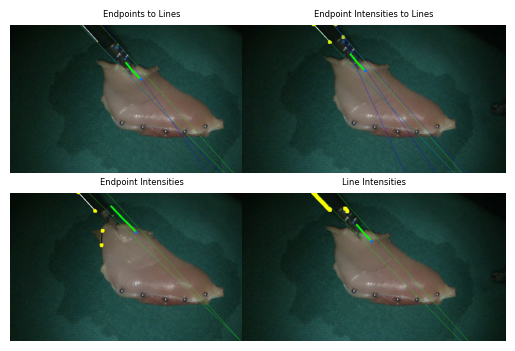

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


img1 = cv2.imread('endp2p.png')
img2 = cv2.imread('endpi2p.png')

img3 = cv2.imread('li.png')
img4 = cv2.imread('endpi.png')


fig, ax = plt.subplots(nrows=2, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
ax[0, 0].set_title('Endpoints to Lines', fontsize = 6)
ax[0, 1].imshow(img2)
ax[0, 1].axis('off')
ax[0, 1].set_title('Endpoint Intensities to Lines', fontsize = 6)
ax[1, 1].imshow(img3)
ax[1, 1].axis('off')
ax[1, 1].set_title('Line Intensities', fontsize = 6)
ax[1, 0].imshow(img4)
ax[1, 0].axis('off')
ax[1, 0].set_title('Endpoint Intensities', fontsize = 6)

plt.subplots_adjust(hspace = -0.17, wspace = -0.12)
plt.savefig('qualitative_results.pdf', bbox_inches = 'tight')

JRN Dataset: 2D

canny_d mean: 20.16777958358722, std: 12.713203102855624
endpi2p_d mean: 44.84362346436493, std: 13.27642167141603
endpi_d mean: 31.25708863774688, std: 10.91450786342805
endp2p_d mean: 20.16906214524759, std: 12.712084402054545
li_d mean: 30.391656688402968, std: 19.288853067521835
li2p_d mean: 23.87380536668057, std: 11.783180420075956


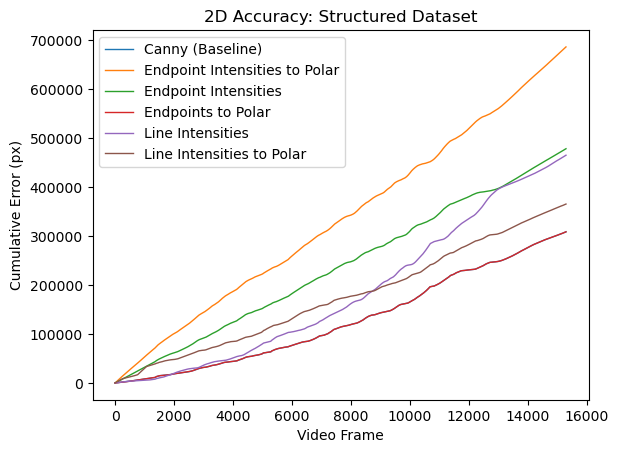

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('ref_data/no_contour/keypoint_labels.csv', header = None, names = ['video_frame', 'x', 'y'])
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
labels.to_pickle('ref_data/no_contour/keypoint_labels.pkl')
labels = np.load('ref_data/no_contour/keypoint_labels.pkl', allow_pickle = True)

canny = pd.read_csv('ref_data/no_contour/canny_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi2p = pd.read_csv('ref_data/no_contour/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi = pd.read_csv('ref_data/no_contour/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi.drop(columns = ['t', 'video_frame'], inplace = True)
endp2p = pd.read_csv('ref_data/no_contour/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endp2p.drop(columns = ['t', 'video_frame'], inplace = True)
li = pd.read_csv('ref_data/no_contour/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
li2p = pd.read_csv('ref_data/no_contour/line_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])

df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    df_list[i]['video_frame'] = np.arange(1, len(labels) + 2)
    df_list[i].drop(columns=['x_d', 'y_d'], inplace = True)
    column_name1 = 'x_' + df_names[i]
    df_list[i][column_name1] = df_list[i]['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df_list[i][column_name2] = df_list[i]['y'].copy()
    df_list[i].drop(columns=['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df_list[i], on = 'video_frame')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    column_name4 = df_names[i] + '_d_cumsum'
    labels[column_name4] = labels[column_name3].cumsum()
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))
   
labels.head()
plt.xlabel('Video Frame')
plt.ylabel('Cumulative Error (px)')
plt.title('2D Accuracy: Structured Dataset')
plt.plot(np.arange(len(labels)), labels['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(labels)), labels['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(labels)), labels['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(labels)), labels['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(labels)), labels['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(labels)), labels['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

labels_SD = labels.copy()

JRN Dataset Abbrev: 2D

canny_d mean: 9.526551450910812, std: 6.504289191051154
endpi2p_d mean: 52.543241574252114, std: 5.384332014625365
endpi_d mean: 32.294879638698774, std: 4.46229364590414
endp2p_d mean: 9.386500839406304, std: 6.6885170715930515
li_d mean: 7.143950788678578, std: 5.570839878419854
li2p_d mean: 27.136171549654268, std: 15.566581988486435


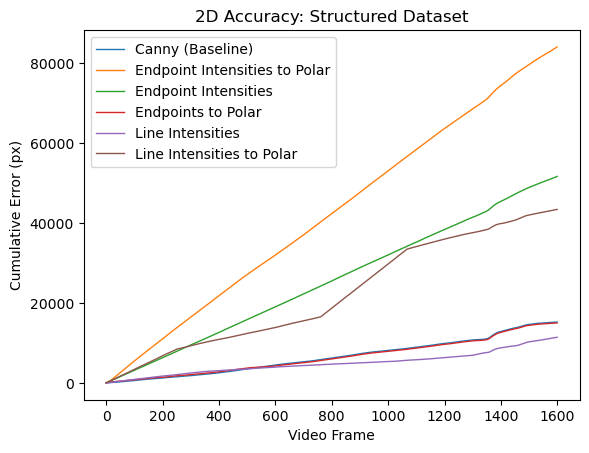

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('ref_data/no_contour/keypoint_labels_abbrev.csv', header = None, names = ['video_frame', 'x', 'y'])
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
labels.to_pickle('ref_data/no_contour/keypoint_labels_abbrev.pkl')
labels = np.load('ref_data/no_contour/keypoint_labels_abbrev.pkl', allow_pickle = True)

canny = pd.read_csv('ref_data/no_contour/canny_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi2p = pd.read_csv('ref_data/no_contour/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
endpi = pd.read_csv('ref_data/no_contour/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi.drop(columns = ['t', 'video_frame'], inplace = True)
endp2p = pd.read_csv('ref_data/no_contour/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endp2p.drop(columns = ['t', 'video_frame'], inplace = True)
li = pd.read_csv('ref_data/no_contour/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])
li2p = pd.read_csv('ref_data/no_contour/line_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['x', 'y', 'x_d', 'y_d'])

df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    df_list[i]['video_frame'] = np.arange(1, len(df_list[i]) + 1)
    df_list[i].drop(columns=['x_d', 'y_d'], inplace = True)
    column_name1 = 'x_' + df_names[i]
    df_list[i][column_name1] = df_list[i]['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df_list[i][column_name2] = df_list[i]['y'].copy()
    df_list[i].drop(columns=['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df_list[i], on = 'video_frame')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    column_name4 = df_names[i] + '_d_cumsum'
    labels[column_name4] = labels[column_name3].cumsum()
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))
   
labels.head()
plt.xlabel('Video Frame')
plt.ylabel('Cumulative Error (px)')
plt.title('2D Accuracy: Structured Dataset')
plt.plot(np.arange(len(labels)), labels['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(labels)), labels['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(labels)), labels['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(labels)), labels['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(labels)), labels['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(labels)), labels['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

labels_SD = labels.copy()

Fei Dataset: 2D

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('fei_ref_data/keypoint_labels_v2.csv', header = None, names = ['t', 'video_frame', 'x', 'y'])
df.drop(columns = ['t'], inplace = True)
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
#labels.to_pickle('fei_ref_data/keypoint_labels_v2.pkl')
labels = np.load('fei_ref_data/keypoint_labels_v2.pkl', allow_pickle = True)
labels.head()

,video_frame,x,y
0,1,41.0,25.0
1,2,41.0,25.0
2,3,42.5,29.5
3,4,44.0,34.0
4,5,45.0,42.0


11689
canny_d mean: 62.7287987855572, std: 24.006614534221086
endpi2p_d mean: 46.50957543600955, std: 23.756234299253325
endpi_d mean: 63.093854342871865, std: 22.952615368690594
endp2p_d mean: 62.806432477032956, std: 24.213680206960355
li_d mean: 63.09435369535788, std: 22.95276940712378
li2p_d mean: 62.806432477032956, std: 24.213680206960355


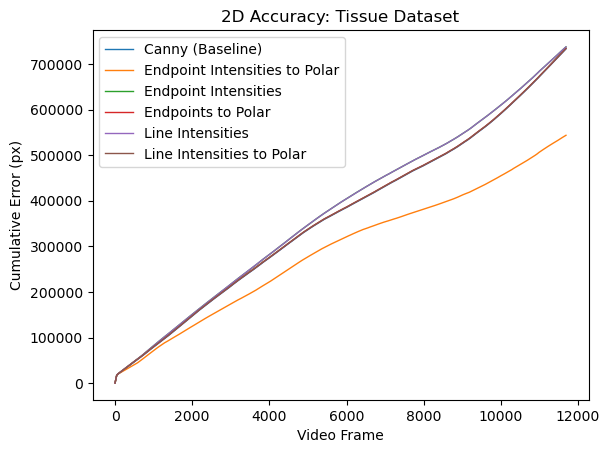

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
labels = np.load('fei_ref_data/keypoint_labels_v2.pkl', allow_pickle = True)
print(len(labels))
canny = pd.read_csv('fei_ref_data/canny_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi2p = pd.read_csv('fei_ref_data/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi = pd.read_csv('fei_ref_data/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endp2p = pd.read_csv('fei_ref_data/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
li = pd.read_csv('fei_ref_data/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
li2p = pd.read_csv('fei_ref_data/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    temp = df_list[i].copy()
    temp.drop(columns=['t', 'x_d', 'y_d'], inplace = True)
    temp['video_frame'] = temp['video_frame'].astype('int')
    temp['x'] = temp['x'].astype('int')
    temp['y'] = temp['y'].astype('int')
    grouped = temp.groupby('video_frame', as_index = False)
    temp = grouped.mean().copy()
    df = pd.DataFrame({'video_frame': np.arange(1, temp['video_frame'].max() + 1)})
    df['video_frame'] = df['video_frame'].astype('int')
    df = pd.merge(left = df, right = temp, how = 'left', on = 'video_frame')
    df['x'].interpolate(method = 'linear', inplace = True)
    df['x'].fillna(method = 'ffill', inplace = True)
    df['x'].fillna(method = 'bfill', inplace = True)
    df['y'].interpolate(method = 'linear', inplace = True)
    df['y'].fillna(method = 'ffill', inplace = True)
    df['y'].fillna(method = 'bfill', inplace = True)
    column_name1 = 'x_' + df_names[i]
    df[column_name1] = df['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df[column_name2] = df['y'].copy()
    df.drop(columns = ['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df, on = 'video_frame', how = 'left')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    column_name4 = df_names[i] + '_d_cumsum'
    labels[column_name4] = labels[column_name3].cumsum()
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))

labels.head()
plt.xlabel('Video Frame')
plt.ylabel('Cumulative Error (px)')
plt.title('2D Accuracy: Tissue Dataset')
plt.plot(np.arange(len(labels)), labels['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(labels)), labels['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(labels)), labels['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(labels)), labels['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(labels)), labels['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(labels)), labels['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

labels_TD = labels.copy()

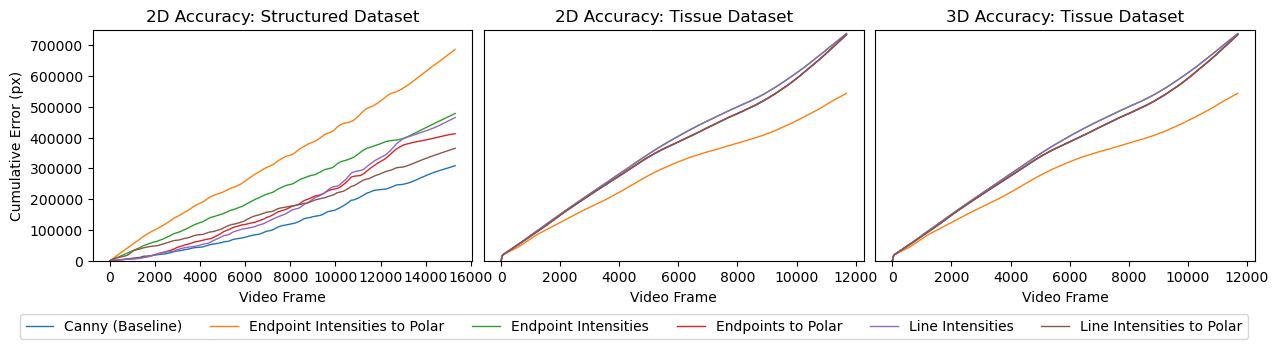

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec


fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 3))

ylim = (0, 750000)

ax[0].set_xlabel('Video Frame')
ax[0].set_ylabel('Cumulative Error (px)')
ax[0].set_title('2D Accuracy: Structured Dataset')
ax[0].set_ylim(ylim)
ax[0].plot(np.arange(len(labels_SD)), labels_SD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[0].legend()

ax[1].set_xlabel('Video Frame')
ax[1].set_ylabel('Cumulative Error (px)')
ax[1].set_title('2D Accuracy: Tissue Dataset')
ax[1].set_ylim(ylim)
ax[1].axes.get_yaxis().set_visible(False)
ax[1].plot(np.arange(len(labels_TD)), labels_TD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[1].legend()

ax[2].set_xlabel('Video Frame')
ax[2].set_ylabel('Cumulative Error (px)')
ax[2].set_title('3D Accuracy: Tissue Dataset')
ax[2].set_ylim(ylim)
ax[2].axes.get_yaxis().set_visible(False)
ax[2].plot(np.arange(len(labels_TD)), labels_TD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[2].legend()

plt.legend(ncol = 6, bbox_to_anchor = (1.0, -0.2))

plt.subplots_adjust(wspace = 0.03)
plt.savefig('cum_error.pdf', bbox_inches = 'tight')